# **Classification of the "Intel Image Classification" Dataset**

We Start by importing the needed libraries

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

from random import randint as rand
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.transforms import v2
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
path = Path("./Data/seg_train/seg_train")

img = []
targets = []

for folder in path.iterdir():
    for file in folder.iterdir():
        img.append(v2.Resize((150,150))(read_image(str(file))))
        targets.append(folder.name)

In [4]:
img = torch.stack(img)

In [5]:
target_dict = np.unique(targets)
targets = torch.tensor([np.where(target_dict == target)[0][0] for target in targets])

In [6]:
class ImageDataset(Dataset):
    def __init__(self, img, targets):
        self.img = img.clone().detach().to(device).to(torch.float32)
        self.targets = targets.clone().detach().to(device).to(torch.float32)

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        img = self.img[idx]
        target = self.targets[idx]
        return img, target

In [7]:
data = ImageDataset(img, targets)

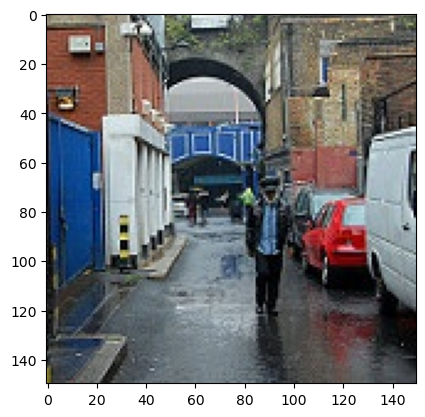

In [8]:
r = rand(0, len(img))
plt.imshow(v2.ToPILImage()(img[r]))
plt.show()

In [9]:
r

12704

In [10]:
targets[r]

tensor(5)

Data targets:

0. buildings
1. forest
2. glacier
3. mountain
4. sea
5. street

In [11]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # Input size - Kernel size / Stride + 1 = Output size (6,146,146)
        self.pool = nn.MaxPool2d(2, 2) # Divide the size by 2 (6,73,73)
        self.conv2 = nn.Conv2d(6, 16, 5) # (16,69,69) -> (16,34,34) (Because of the pooling layer (again)) -> Flatten (16*34*34) = 18496
        
        #Dense layers
        
        self.fc1 = nn.Linear(16 * 34 * 34, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
model = Model()
model.cuda()

Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=18496, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)

In [18]:
criterion = nn.L1Loss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [19]:
data.img.dtype

torch.float32

In [20]:
data.targets.dtype

torch.float32

In [21]:
loader = DataLoader(data, batch_size=4, shuffle=True)

epoch = 10
for e in range(epoch):
    for i, (img, target) in enumerate(loader):
        target = target.unsqueeze(1)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f"Epoch: {e}, Loss: {loss}")

/home/mikhail/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 0, Loss: 2.9803473949432373
Epoch: 0, Loss: 1.749996542930603
Epoch: 0, Loss: 2.3727471828460693
Epoch: 0, Loss: 2.000277519226074
Epoch: 0, Loss: 0.8950891494750977
Epoch: 0, Loss: 0.75
Epoch: 0, Loss: 1.2508103847503662
Epoch: 0, Loss: 1.119137167930603
Epoch: 0, Loss: 1.25
Epoch: 0, Loss: 1.8789644241333008
Epoch: 0, Loss: 2.243258237838745
Epoch: 0, Loss: 1.5683555603027344
Epoch: 0, Loss: 1.0
Epoch: 0, Loss: 1.0976319313049316
Epoch: 0, Loss: 1.4454073905944824
Epoch: 0, Loss: 1.25
Epoch: 0, Loss: 1.0353572368621826
Epoch: 0, Loss: 1.499441146850586
Epoch: 0, Loss: 1.2922520637512207
Epoch: 0, Loss: 1.5657991170883179
Epoch: 0, Loss: 1.0
Epoch: 0, Loss: 1.357787847518921
Epoch: 0, Loss: 1.4928078651428223
Epoch: 0, Loss: 0.5794322490692139
Epoch: 0, Loss: 1.0660611391067505
Epoch: 0, Loss: 1.795175552368164
Epoch: 0, Loss: 1.7490065097808838
Epoch: 0, Loss: 2.2020957469940186
Epoch: 0, Loss: 0.06196099519729614
Epoch: 0, Loss: 1.8715996742248535
Epoch: 0, Loss: 1.1259468793

/home/mikhail/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 1, Loss: 1.6996948719024658
Epoch: 1, Loss: 2.2920966148376465
Epoch: 1, Loss: 1.0
Epoch: 1, Loss: 2.0
Epoch: 1, Loss: 1.2242558002471924
Epoch: 1, Loss: 1.5
Epoch: 1, Loss: 2.270714521408081
Epoch: 1, Loss: 1.0546754598617554
Epoch: 1, Loss: 0.5301041007041931
Epoch: 1, Loss: 1.0
Epoch: 1, Loss: 1.0831935405731201
Epoch: 1, Loss: 1.5
Epoch: 1, Loss: 1.728123426437378
Epoch: 1, Loss: 0.7979742884635925
Epoch: 1, Loss: 1.709284782409668
Epoch: 1, Loss: 1.2361525297164917
Epoch: 1, Loss: 1.0
Epoch: 1, Loss: 1.2375669479370117
Epoch: 1, Loss: 2.001368284225464
Epoch: 1, Loss: 1.5055561065673828
Epoch: 1, Loss: 1.4655301570892334
Epoch: 1, Loss: 1.3635814189910889
Epoch: 1, Loss: 1.4876301288604736
Epoch: 1, Loss: 2.0
Epoch: 1, Loss: 1.3171989917755127
Epoch: 1, Loss: 1.5
Epoch: 1, Loss: 1.747995376586914
Epoch: 1, Loss: 1.5000652074813843
Epoch: 1, Loss: 1.6680258512496948
Epoch: 1, Loss: 2.4408140182495117
Epoch: 1, Loss: 1.7191842794418335
Epoch: 1, Loss: 2.1583125591278076
Epoch

In [22]:
model.eval()

Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=18496, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)

In [23]:
def predict(img):
    img = img.unsqueeze(0)
    p = model(img)
    print(p)
    return target_dict[p.argmax()]

In [121]:
r = rand(0, len(img))
print(predict(data.img[r]))
print(data.targets[r])

tensor([[3.0865, 3.0941, 3.1166, 3.0780, 3.0937, 3.1095]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
glacier
tensor(0., device='cuda:0')
